# Store Item Demand Forecasting Challenge
>https://www.kaggle.com/c/demand-forecasting-kernels-only/overview






Best Score <br>
Experiment 6: Ensembled model (Improved Prophet + Tuned Catboost + Rounding) <br>
Rank 98/459 on private leaderboard (top 21%) <br>
Rank 119/459 on public leaderboard (top 25%) <br>
<br>
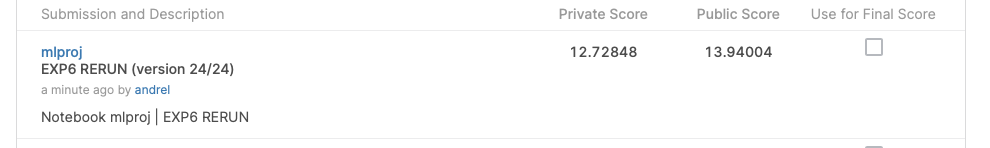

## Imports


In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score

In [82]:
# train.csv
train_df = pd.read_csv("train.csv")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [83]:
# test.csv
test_df = pd.read_csv("test.csv")
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [84]:
# sample_submission.csv
sample_df = pd.read_csv("sample_submission.csv")
sample_df.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


Exploration

## Data Preparation

In [90]:
from datetime import datetime

def convertYMD(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = [i.year for i in df['date']]
    df['month'] = [i.month for i in df['date']]
    df['day'] = [i.dayofweek for i in df['date']]

In [91]:
convertYMD(train_df)
train_df.drop('date', axis=1, inplace=True)
train_df.head()

,store,item,sales,year,month,day
0,1,1,13,2013,1,1
1,1,1,11,2013,1,2
2,1,1,14,2013,1,3
3,1,1,13,2013,1,4
4,1,1,10,2013,1,5


In [98]:
convertYMD(test_df)
test_df.drop('date', axis=1, inplace=True)
test_df.head()

,id,store,item,year,month,day
0,0,1,1,2018,1,0
1,1,1,1,2018,1,1
2,2,1,1,2018,1,2
3,3,1,1,2018,1,3
4,4,1,1,2018,1,4


In [99]:
# drop id column before predicting
test_df.drop('id', axis=1, inplace=True)

# Baseline ML Models

In [102]:
train_df = pd.read_csv("train.csv")
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [103]:
# split train_df into 2 validation and train set
val = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # first 3 months of 2017
train = pd.concat([train_df, val, val]).drop_duplicates(keep=False) # the rest of the months

x-labels

In [104]:
convertYMD(train)
train.drop('date', axis=1, inplace=True)
train

,store,item,sales,year,month,day
0,1,1,13,2013,1,1
1,1,1,11,2013,1,2
2,1,1,14,2013,1,3
3,1,1,13,2013,1,4
4,1,1,10,2013,1,5
...,...,...,...,...,...,...
912995,10,50,63,2017,12,2
912996,10,50,59,2017,12,3
912997,10,50,74,2017,12,4
912998,10,50,62,2017,12,5


In [105]:
convertYMD(val)
val.drop('date', axis=1, inplace=True)
val

/var/folders/ny/vyccgwl94n39q3y435x80g540000gn/T/ipykernel_13754/3823085543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/var/folders/ny/vyccgwl94n39q3y435x80g540000gn/T/ipykernel_13754/3823085543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = [i.year for i in df['date']]
/var/folders/ny/vyccgwl94n39q3y435x80g540000gn/T/ipykernel_13754/3823085543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,store,item,sales,year,month,day
1461,1,1,19,2017,1,6
1462,1,1,15,2017,1,0
1463,1,1,10,2017,1,1
1464,1,1,16,2017,1,2
1465,1,1,14,2017,1,3
...,...,...,...,...,...,...
912720,10,50,66,2017,3,0
912721,10,50,60,2017,3,1
912722,10,50,73,2017,3,2
912723,10,50,68,2017,3,3


y-labels

In [110]:
sales_val = val.pop('sales')
sales_val

1461      19
1462      15
1463      10
1464      16
1465      14
          ..
912720    66
912721    60
912722    73
912723    68
912724    69
Name: sales, Length: 45000, dtype: int64

In [111]:
sales_train = train.pop('sales')
sales_train

0         13
1         11
2         14
3         13
4         10
          ..
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 868000, dtype: int64

In [112]:
test_df

,store,item,year,month,day
0,1,1,2018,1,0
1,1,1,2018,1,1
2,1,1,2018,1,2
3,1,1,2018,1,3
4,1,1,2018,1,4
...,...,...,...,...,...
44995,10,50,2018,3,1
44996,10,50,2018,3,2
44997,10,50,2018,3,3
44998,10,50,2018,3,4


In [113]:
print(train.shape, val.shape, test_df.shape)

(868000, 5) (45000, 5) (45000, 5)


In [114]:
def regression_report(y_true, y_pred):
    metrics = [('SMAPE', (100/len(y_pred) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_pred) + np.abs(y_true))))),
               ('MAE', mean_absolute_error(y_true, y_pred)),
               ('Median Absolute Error', median_absolute_error(y_true, y_pred)),
               ('Mean Squared Error', mean_squared_error(y_true, y_pred)),
               ('Max Error', max_error(y_true, y_pred)),
               ('R2 Score', r2_score(y_true, y_pred)),
               ('Explained Variance Score', explained_variance_score(y_true, y_pred))]

    # Init scoring metrics
    regression_report_df = pd.DataFrame(columns=['Metric Name', 'Score'])
    dfs = []
    for name, score in metrics:
        df = pd.DataFrame([[name, score]], columns=['Metric Name', 'Score'])
        dfs.append(df)
    regression_report_df = pd.concat(dfs, ignore_index=True)
              
    return regression_report_df

## Catboost

In [115]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', n_estimators = 200, eta = 0.3, random_seed=1)
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds = 20, eval_set=(val.values, sales_val.values))

0:	learn: 25.5508294	test: 22.0294744	best: 22.0294744 (0)	total: 58.4ms	remaining: 11.6s
1:	learn: 23.5569327	test: 20.0034748	best: 20.0034748 (1)	total: 112ms	remaining: 11.1s
2:	learn: 21.9270142	test: 18.7698309	best: 18.7698309 (2)	total: 169ms	remaining: 11.1s
3:	learn: 20.8556084	test: 17.8652701	best: 17.8652701 (3)	total: 225ms	remaining: 11s
4:	learn: 19.8948580	test: 17.1182411	best: 17.1182411 (4)	total: 291ms	remaining: 11.3s
5:	learn: 18.9128838	test: 16.1631390	best: 16.1631390 (5)	total: 355ms	remaining: 11.5s
6:	learn: 18.1926212	test: 15.4094859	best: 15.4094859 (6)	total: 419ms	remaining: 11.6s
7:	learn: 17.6572749	test: 14.9678126	best: 14.9678126 (7)	total: 483ms	remaining: 11.6s
8:	learn: 16.4071182	test: 13.7564503	best: 13.7564503 (8)	total: 549ms	remaining: 11.6s
9:	learn: 15.3101600	test: 12.6974150	best: 12.6974150 (9)	total: 613ms	remaining: 11.6s
10:	learn: 14.5357008	test: 11.9557628	best: 11.9557628 (10)	total: 679ms	remaining: 11.7s
11:	learn: 14.064054

95:	learn: 7.5336343	test: 6.9769120	best: 6.9769120 (95)	total: 7.39s	remaining: 8s
96:	learn: 7.5277992	test: 6.9762160	best: 6.9762160 (96)	total: 7.47s	remaining: 7.94s
97:	learn: 7.5234872	test: 6.9710952	best: 6.9710952 (97)	total: 7.56s	remaining: 7.86s
98:	learn: 7.5167481	test: 6.9675198	best: 6.9675198 (98)	total: 7.63s	remaining: 7.79s
99:	learn: 7.5085112	test: 6.9646289	best: 6.9646289 (99)	total: 7.72s	remaining: 7.72s
100:	learn: 7.5027549	test: 6.9665325	best: 6.9646289 (99)	total: 7.8s	remaining: 7.64s
101:	learn: 7.4978205	test: 6.9649231	best: 6.9646289 (99)	total: 7.88s	remaining: 7.57s
102:	learn: 7.4922063	test: 6.9614589	best: 6.9614589 (102)	total: 7.96s	remaining: 7.5s
103:	learn: 7.4882166	test: 6.9617693	best: 6.9614589 (102)	total: 8.05s	remaining: 7.43s
104:	learn: 7.4828752	test: 6.9605668	best: 6.9605668 (104)	total: 8.13s	remaining: 7.36s
105:	learn: 7.4776112	test: 6.9595626	best: 6.9595626 (105)	total: 8.22s	remaining: 7.29s
106:	learn: 7.4673875	test:

188:	learn: 7.3015616	test: 6.8750965	best: 6.8750646 (185)	total: 14.6s	remaining: 852ms
189:	learn: 7.3007113	test: 6.8747082	best: 6.8747082 (189)	total: 14.7s	remaining: 775ms
190:	learn: 7.2999543	test: 6.8744921	best: 6.8744921 (190)	total: 14.8s	remaining: 697ms
191:	learn: 7.2988630	test: 6.8743118	best: 6.8743118 (191)	total: 14.9s	remaining: 619ms
192:	learn: 7.2974087	test: 6.8738520	best: 6.8738520 (192)	total: 14.9s	remaining: 542ms
193:	learn: 7.2967245	test: 6.8733259	best: 6.8733259 (193)	total: 15s	remaining: 464ms
194:	learn: 7.2957456	test: 6.8726316	best: 6.8726316 (194)	total: 15.1s	remaining: 387ms
195:	learn: 7.2953455	test: 6.8723888	best: 6.8723888 (195)	total: 15.2s	remaining: 309ms
196:	learn: 7.2946150	test: 6.8723623	best: 6.8723623 (196)	total: 15.2s	remaining: 232ms
197:	learn: 7.2936375	test: 6.8723975	best: 6.8723623 (196)	total: 15.3s	remaining: 155ms
198:	learn: 7.2927152	test: 6.8722440	best: 6.8722440 (198)	total: 15.4s	remaining: 77.2ms
199:	learn:

In [116]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,13.470677
1,MAE,5.308890
2,Median Absolute Error,4.244043
3,Mean Squared Error,47.227441
4,Max Error,36.376568
5,R2 Score,0.916615
6,Explained Variance Score,0.916844


In [117]:
y_pred = model.predict(test_df.values)

sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_cb.csv", index=False)
sample_df.head()

,id,sales
0,0,12.024849
1,1,13.822182
2,2,13.872539
3,3,14.491420
4,4,15.831704


## Decision Tree

In [118]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(train.values, sales_train.values)

DecisionTreeRegressor()

In [119]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.971560
1,MAE,5.914089
2,Median Absolute Error,4.750000
3,Mean Squared Error,59.487114
4,Max Error,46.250000
5,R2 Score,0.894970
6,Explained Variance Score,0.899911


In [120]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_dt.csv", index=False)
sample_df.head()

,id,sales
0,0,10.25
1,1,15.00
2,2,13.00
3,3,14.75
4,4,15.40


## Light GBM

In [122]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds=20, eval_set=(val.values, sales_val.values))

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,16.073
1,MAE,6.261
2,Median Absolute Error,5.224
3,Mean Squared Error,63.384
4,Max Error,49.278
5,R2 Score,0.888
6,Explained Variance Score,0.892


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_lgbm.csv", index=False)
sample_df.head()

,id,sales
0,0,16.561062
1,1,17.444016
2,2,17.444016
3,3,18.268907
4,4,17.977213


## Linear Regression

In [123]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train.values, sales_train.values)

LinearRegression()

In [124]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,48.924073
1,MAE,22.670578
2,Median Absolute Error,21.663495
3,Mean Squared Error,717.115720
4,Max Error,90.322757
5,R2 Score,-0.266139
6,Explained Variance Score,0.066234


In [125]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_lr.csv", index=False)
sample_df.head()

,id,sales
0,0,57.005051
1,1,60.219296
2,2,63.433540
3,3,66.647785
4,4,69.862029


## Random Forest

In [126]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, n_jobs=-1)
model.fit(train.values, sales_train.values)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [127]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.944843
1,MAE,5.904205
2,Median Absolute Error,4.679811
3,Mean Squared Error,59.290824
4,Max Error,46.178482
5,R2 Score,0.895316
6,Explained Variance Score,0.900300


In [128]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_rf.csv", index=False)
sample_df.head()

,id,sales
0,0,10.255562
1,1,15.098450
2,2,12.936129
3,3,14.649468
4,4,15.387590


## XGBoost

In [130]:
import xgboost
model = xgboost.XGBRegressor(n_estimators = 200, seed = 21)
model.fit(train.values, sales_train.values, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=21, ...)

In [131]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.064043
1,MAE,5.522580
2,Median Absolute Error,4.433034
3,Mean Squared Error,50.913739
4,Max Error,38.642258
5,R2 Score,0.910107
6,Explained Variance Score,0.910661


In [132]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_xgb.csv", index=False)
sample_df.head()

,id,sales
0,0,14.757501
1,1,16.119011
2,2,16.984201
3,3,13.956003
4,4,15.874704


## MLP (Neural Network)

In [134]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(32,32,32), activation="relu", random_state=1, max_iter=20).fit(train.values, sales_train.values)

/Users/QianYi/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [135]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,37.410320
1,MAE,15.518736
2,Median Absolute Error,12.422675
3,Mean Squared Error,406.063925
4,Max Error,102.058914
5,R2 Score,0.283054
6,Explained Variance Score,0.323098


In [136]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_mlp.csv", index=False)
sample_df.head()

,id,sales
0,0,4.529868
1,1,5.776620
2,2,7.023372
3,3,8.831623
4,4,10.765563


# Prophet

In [ ]:
# !pip install fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics, cross_validation

In [ ]:
print(len(val.index.unique()))

45000


In [ ]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("https://drive.google.com/uc?id=1h-vNpZ0RJnsuLxCTs0qc80jwGNrGeX49")

train = train_df.loc[(train_df["date"] < "2017-01-01"), :] # everything else before that
train['date'] = pd.to_datetime(train['date'])
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
test['date'] = pd.to_datetime(test['date'])

results = test.reset_index()
results['sales'] = 0 # init sales col

stores = train['store'].unique()
items = train['item'].unique()
period = len(test.index.unique()

# run the model through each of the 10 stores and 50 items
for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        
        model = Prophet()
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=period, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat']

In [ ]:
y_pred = forecast['yhat']
y_pred

0         37.110053
1         23.482380
2         28.701794
3         27.727860
4         31.226709
            ...    
44995    308.166995
44996    310.274033
44997    296.770137
44998    302.139523
44999    301.341779
Name: yhat, Length: 45000, dtype: float64

In [ ]:
val = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
val = val.reset_index()
val.sales

0        19
1        15
2        10
3        16
4        14
         ..
44995    66
44996    60
44997    73
44998    68
44999    69
Name: sales, Length: 45000, dtype: int64

In [ ]:
regression_report(val.sales, y_pred)

,Metric Name,Score
0,SMAPE,108.639
1,MAE,128.662
2,Median Absolute Error,124.724
3,Mean Squared Error,23158.240
4,Max Error,303.351
5,R2 Score,-39.888
6,Explained Variance Score,-10.989


## Improving Prophet: With Prophet built in holidays

In [ ]:
train = pd.read_csv("https://drive.google.com/uc?id=1h-vNpZ0RJnsuLxCTs0qc80jwGNrGeX49", parse_dates=['date'], index_col=['date'])
test = pd.read_csv("https://drive.google.com/uc?id=1i01pfTSwINi_SBEZhZCG_oZ8C2s6zqWa", parse_dates=['date'], index_col=['date'])

results = test.reset_index()
results['sales'] = 0

stores = train_df['store'].unique()
items = train_df['item'].unique()
period = len(test.index.unique()

# run the model through each of the 10 stores and 50 items
for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        
        training_df['y'] = np.log1p(training_df['y'])
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.add_country_holidays(country_name='US')
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=period, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = np.expm1(forecast['yhat']).values

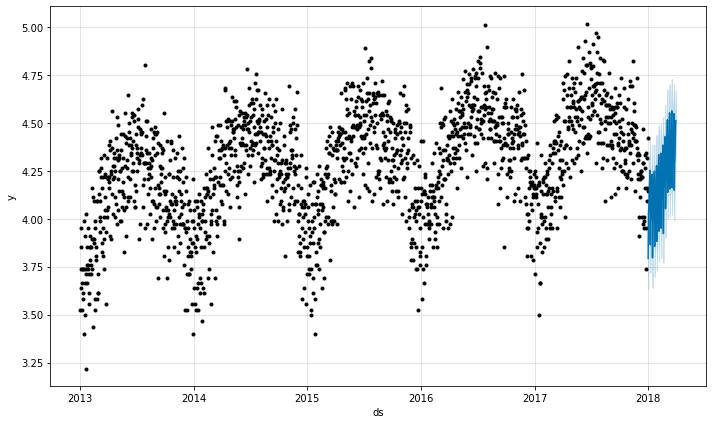

In [ ]:
forecastplot = model.plot(forecast)

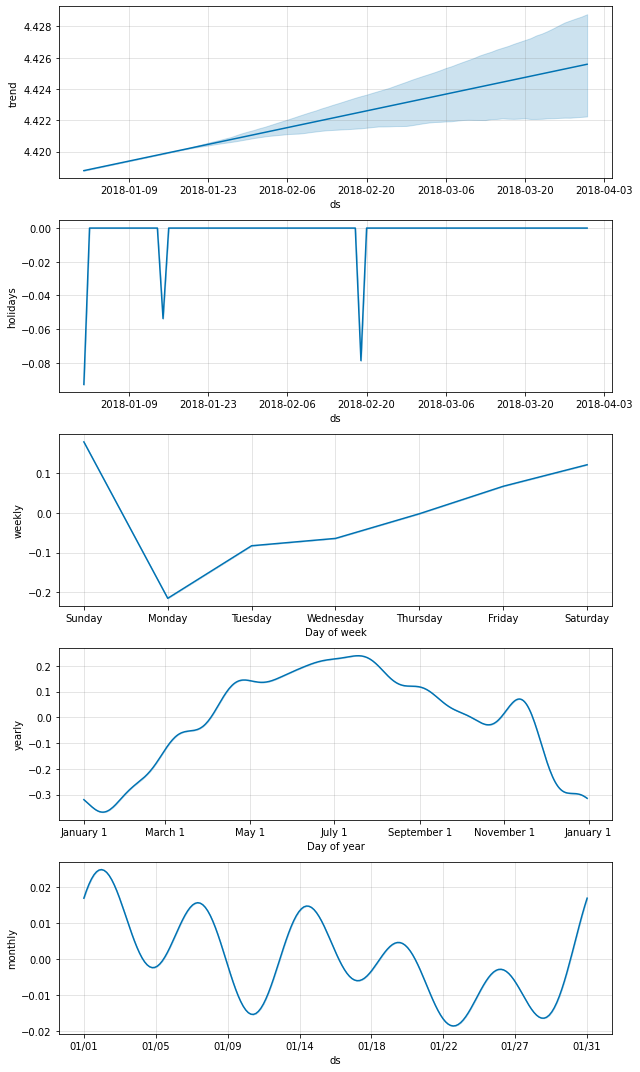

In [ ]:
fig = model.plot_components(forecast)

In [ ]:
results.drop(['date', 'store', 'item'], axis=1, inplace=True)
results.to_csv('/content/Prophet_2.csv', index=False)

In [ ]:
results

,id,sales
0,0,12.637813
1,1,14.161476
2,2,14.951993
3,3,15.697017
4,4,17.084651
...,...,...
44995,44995,71.625001
44996,44996,73.835699
44997,44997,79.445003
44998,44998,85.424078


In [ ]:
test_results = results
test_results['sales'] = np.round(test_results['sales']).astype(int) # round the result to whole number

In [ ]:
test_results

,id,sales
0,0,13
1,1,14
2,2,15
3,3,16
4,4,17
...,...,...
44995,44995,72
44996,44996,74
44997,44997,79
44998,44998,85


In [ ]:
# rounded off results is better than non-rounded
test_results.to_csv('/content/Prophet_3.csv', index=False) 

In [ ]:
model.train_holiday_names

0                     4th of July
1                   Christmas Day
2                   Christmas Eve
3                    Columbus Day
4                  Eastern Easter
5                      Juneteenth
6                       Labor Day
7               Labor Day Weekend
8     Martin Luther King, Jr. Day
9                    Memorial Day
10                 New Year's Day
11                 New Year’s Eve
12               Thanksgiving Day
13               Thanksgiving Eve
14                Valentine’s Day
15                   Veterans Day
16          Washington's Birthday
17                 Western Easter
dtype: object

## Improving Prophet: With holiday dataset from Kaggle

In [ ]:
holidays = pd.read_csv("/content/holidays.csv")
holidays.head()

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008


In [ ]:
holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True)
holidays['ds'] = pd.to_datetime(holidays['ds']) 
holidays = holidays[(holidays['ds']>df.iloc[0]['date'])&(holidays['ds']<df.iloc[-1]['date'])]

results = test.reset_index()
results['sales'] = 0

period = len(test.index.unique()

In [ ]:
for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y']) # log transform
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=period, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = np.expm1(forecast['yhat']).values # undo log transform

In [ ]:
results.drop(['date', 'store', 'item'], axis=1, inplace=True)
results['sales'] = np.round(results['sales']).astype(int) # round to whole number
results.to_csv('Prophet.csv', index=False)

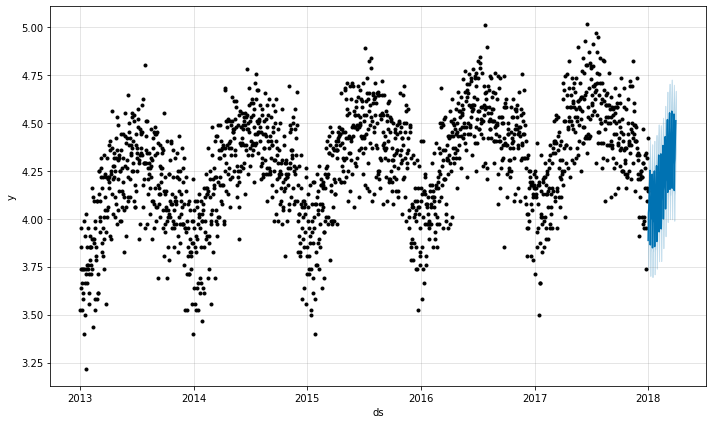

In [ ]:
forecastplot = model.plot(forecast)

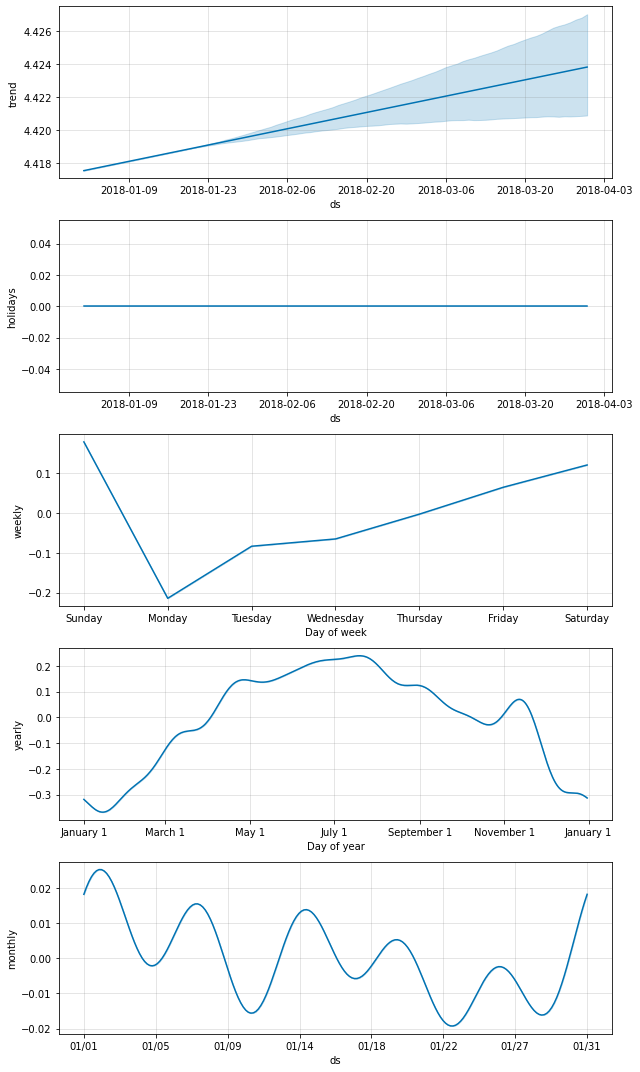

In [ ]:
fig = model.plot_components(forecast)

In [ ]:
results

,id,sales
0,0,12
1,1,14
2,2,15
3,3,16
4,4,17
...,...,...
44995,44995,71
44996,44996,74
44997,44997,79
44998,44998,85


## Improving Prophet: Seasonality (fourier order 3 instead of 5)

In [ ]:
results = test.reset_index()
results['sales']
period = len(test.index.unique()

for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y'])
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=3)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=period), include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = np.expm1(forecast['yhat']).values
        

In [ ]:
results.drop(['date', 'store', 'item'], axis=1, inplace=True)
results

,id,sales
0,0,12.207346
1,1,14.427157
2,2,15.110521
3,3,15.670585
4,4,17.098792
...,...,...
44995,44995,71.667987
44996,44996,74.162776
44997,44997,79.202091
44998,44998,84.430301


In [ ]:
results.to_csv('/content/submission_prophet_1.csv', index=False)

In [ ]:
# rounding
results['sales'] = np.round(results['sales']).astype(int)
results.to_csv('/content/submission_prophet.csv', index=False)

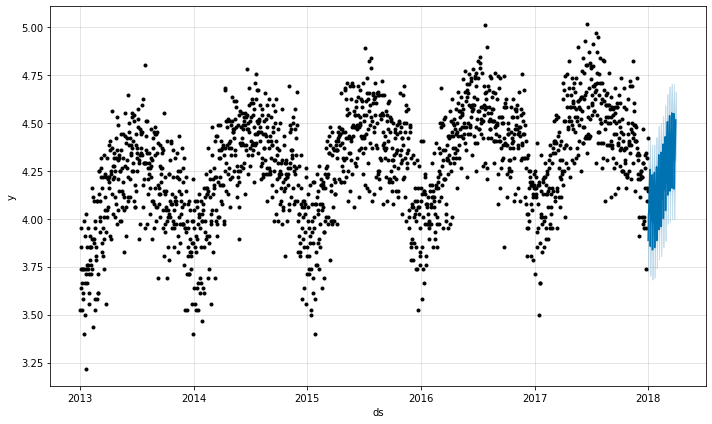

In [ ]:
forecastplot = model.plot(forecast)

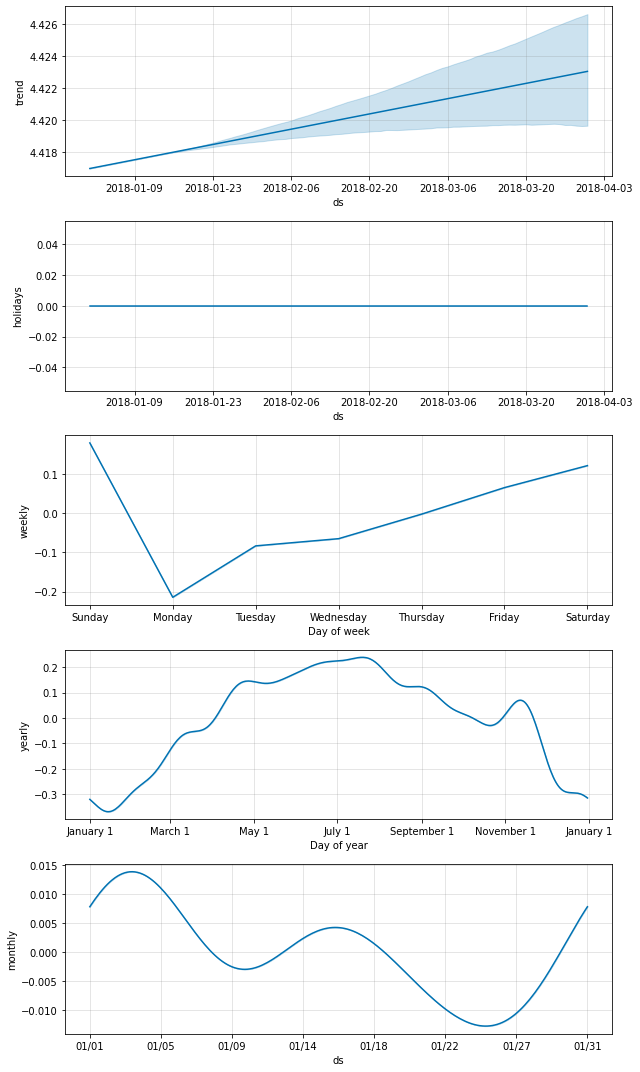

In [ ]:
fig = model.plot_components(forecast)

# Proposed Solution

## Retraining Best Baseline Model - Catboost


> Previously, the baseline models were trained on segmented data to evaluate the performance of each model. As Prophet was trained with the entire training dataset provided without splitting, the catboost model will be trained here in entirety. 



In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', n_estimators = 200, eta = 0.3, random_seed=1)
model.fit(train_df.values, sales.values, verbose=True, early_stopping_rounds = 20)

0:	learn: 25.4256417	total: 189ms	remaining: 37.5s
1:	learn: 23.3958282	total: 321ms	remaining: 31.8s
2:	learn: 21.7787433	total: 459ms	remaining: 30.1s
3:	learn: 20.7197062	total: 588ms	remaining: 28.8s
4:	learn: 19.7039599	total: 727ms	remaining: 28.4s
5:	learn: 18.4625731	total: 851ms	remaining: 27.5s
6:	learn: 17.7278400	total: 981ms	remaining: 27s
7:	learn: 17.1725377	total: 1.11s	remaining: 26.7s
8:	learn: 16.1825475	total: 1.24s	remaining: 26.4s
9:	learn: 15.7367935	total: 1.38s	remaining: 26.2s
10:	learn: 15.0529448	total: 1.51s	remaining: 25.9s
11:	learn: 14.5622384	total: 1.63s	remaining: 25.6s
12:	learn: 14.1020665	total: 1.76s	remaining: 25.4s
13:	learn: 13.7792573	total: 1.89s	remaining: 25.2s
14:	learn: 12.9406582	total: 2.03s	remaining: 25.1s
15:	learn: 12.7605545	total: 2.16s	remaining: 24.8s
16:	learn: 12.5292946	total: 2.29s	remaining: 24.7s
17:	learn: 12.2034357	total: 2.43s	remaining: 24.5s
18:	learn: 11.9254898	total: 2.56s	remaining: 24.4s
19:	learn: 11.6083783	to

In [ ]:
y_pred = model.predict(test_df.values)

In [ ]:
# init sample_submission.csv
sample_df = pd.read_csv("https://drive.google.com/uc?id=1VUhb4Jv2BbeE3jLef3vuTMhWDnf3z_JD")
sample_df['sales'] = y_pred
sample_df.head()

,id,sales
0,0,12.008563
1,1,14.380009
2,2,14.351157
3,3,14.701971
4,4,16.222832


In [ ]:
sample_df.to_csv("submission_catboost.csv", index=False)

## Ensembling Experiments (Before Tuning)

Experiment 1 (without rounding)

In [ ]:
# both df had no rounding
import pandas as pd
df1 = pd.read_csv("/content/submission_catboost.csv")
df2 = pd.read_csv("/content/submission_prophet_1.csv")

In [ ]:
df1.head(3)

,id,sales
0,0,12.008563
1,1,14.380009
2,2,14.351157


In [ ]:
df2.head(3)

,id,sales
0,0,12.207346
1,1,14.427157
2,2,15.110521


In [ ]:
df3 = df1 # make a duplicate
df3['sales'] = (0.5*df1['sales']) + (0.5*df2['sales'])

In [ ]:
df3

,id,sales
0,0,12.107955
1,1,14.403583
2,2,14.730839
3,3,15.186278
4,4,16.660812
...,...,...
44995,44995,70.202505
44996,44996,71.722354
44997,44997,76.954068
44998,44998,81.995826


In [ ]:
df3.to_csv('/content/submission_ens.csv', index=False) 

Experiment 2 (with rounding)

In [ ]:
import numpy as np
df4 = df3
df4['sales'] = np.round(df4['sales']).astype(int) # round the result to whole number

In [ ]:
df4

,id,sales
0,0,12
1,1,14
2,2,15
3,3,15
4,4,17
...,...,...
44995,44995,70
44996,44996,72
44997,44997,77
44998,44998,82


In [ ]:
df4.to_csv('/content/submission_ens2.csv', index=False)

Experiment 3 (changing weightage p1)

In [ ]:
df5 = df1 # make a duplicate
df5['sales'] = (0.4*df1['sales']) + (0.6*df2['sales'])

In [ ]:
df5

,id,sales
0,0,12.127833
1,1,14.408298
2,2,14.806776
3,3,15.283140
4,4,16.748408
...,...,...
44995,44995,70.495601
44996,44996,72.210438
44997,44997,77.403673
44998,44998,82.482721


Experiment 4 (changing weightage p2)

In [ ]:
df6 = df1 # make a duplicate
df6['sales'] = (0.6*df1['sales']) + (0.4*df2['sales'])

In [ ]:
df6

,id,sales
0,0,12.088076
1,1,14.398868
2,2,14.654903
3,3,15.089417
4,4,16.573216
...,...,...
44995,44995,69.909408
44996,44996,71.234269
44997,44997,76.504464
44998,44998,81.508932


In [ ]:
df6.to_csv('/content/submission_ens4.csv', index=False)

In [ ]:
import numpy as np
df6_rounded = df6
df6_rounded['sales'] = np.round(df6_rounded['sales']).astype(int) # round the result to whole number

In [ ]:
df6_rounded

,id,sales
0,0,12
1,1,14
2,2,15
3,3,15
4,4,17
...,...,...
44995,44995,70
44996,44996,71
44997,44997,77
44998,44998,82


In [ ]:
df6_rounded.to_csv('/content/submission_ens4_rounded.csv', index=False)

## Improving Catboost

In [ ]:
!pip install catboost

Gridsearch, 3-fold cross validation

In [ ]:
from catboost import CatBoostRegressor
import numpy as np

model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1, 0.3],
        'max_depth': [8, 10, 12],
        'n_estimators': [100, 200, 300]}

grid_search_result = model.grid_search(grid, cv=3,
                                       X=train_df.values,
                                       y=sales.values,
                                       plot=True)

248:	learn: 7.4430064	test: 7.4504002	best: 7.4504002 (248)	total: 37.9s	remaining: 7.77s
249:	learn: 7.4408384	test: 7.4483488	best: 7.4483488 (249)	total: 38.1s	remaining: 7.61s
250:	learn: 7.4395302	test: 7.4472371	best: 7.4472371 (250)	total: 38.2s	remaining: 7.46s
251:	learn: 7.4362050	test: 7.4443183	best: 7.4443183 (251)	total: 38.4s	remaining: 7.31s
252:	learn: 7.4340164	test: 7.4422954	best: 7.4422954 (252)	total: 38.6s	remaining: 7.16s
253:	learn: 7.4304008	test: 7.4387253	best: 7.4387253 (253)	total: 38.7s	remaining: 7.01s
254:	learn: 7.4290344	test: 7.4374769	best: 7.4374769 (254)	total: 38.9s	remaining: 6.86s
255:	learn: 7.4282030	test: 7.4368605	best: 7.4368605 (255)	total: 39s	remaining: 6.71s
256:	learn: 7.4264636	test: 7.4352616	best: 7.4352616 (256)	total: 39.2s	remaining: 6.55s
257:	learn: 7.4241105	test: 7.4328630	best: 7.4328630 (257)	total: 39.3s	remaining: 6.4s
258:	learn: 7.4221032	test: 7.4309979	best: 7.4309979 (258)	total: 39.5s	remaining: 6.25s
259:	learn: 7

In [ ]:
grid_search_result['params']

{'depth': 10, 'iterations': 300, 'learning_rate': 0.3}

Results based on the best parameters

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', eval_metric='SMAPE', n_estimators = 300, learning_rate = 0.3, random_seed=1)
model.fit(train_df.values, sales.values, verbose=True, early_stopping_rounds=20)

0:	learn: 41.5795955	total: 365ms	remaining: 1m 49s
1:	learn: 38.6645654	total: 664ms	remaining: 1m 38s
2:	learn: 36.0576029	total: 971ms	remaining: 1m 36s
3:	learn: 34.3533438	total: 1.28s	remaining: 1m 35s
4:	learn: 32.6488399	total: 1.57s	remaining: 1m 32s
5:	learn: 30.4234357	total: 1.83s	remaining: 1m 29s
6:	learn: 29.0527015	total: 2.11s	remaining: 1m 28s
7:	learn: 28.1041865	total: 2.36s	remaining: 1m 26s
8:	learn: 26.8656018	total: 2.63s	remaining: 1m 25s
9:	learn: 25.7604630	total: 2.93s	remaining: 1m 25s
10:	learn: 24.1733789	total: 3.2s	remaining: 1m 24s
11:	learn: 23.2873026	total: 3.46s	remaining: 1m 23s
12:	learn: 22.4871595	total: 3.74s	remaining: 1m 22s
13:	learn: 21.8275717	total: 4.05s	remaining: 1m 22s
14:	learn: 20.6263713	total: 4.32s	remaining: 1m 22s
15:	learn: 20.3630003	total: 4.56s	remaining: 1m 20s
16:	learn: 19.8732930	total: 4.85s	remaining: 1m 20s
17:	learn: 19.4232629	total: 5.13s	remaining: 1m 20s
18:	learn: 18.9571909	total: 5.43s	remaining: 1m 20s
19:	

In [ ]:
y_pred = model.predict(test_df.values)

In [ ]:
# init sample_submission.csv
sample_df = pd.read_csv("https://drive.google.com/uc?id=1VUhb4Jv2BbeE3jLef3vuTMhWDnf3z_JD")
sample_df['sales'] = y_pred
sample_df.head()

,id,sales
0,0,11.988715
1,1,13.945223
2,2,14.072181
3,3,14.447243
4,4,16.480513


In [ ]:
sample_df.to_csv("submission_catboost_2.csv", index=False)

In [ ]:
sample_df

,id,sales
0,0,11.988715
1,1,13.945223
2,2,14.072181
3,3,14.447243
4,4,16.480513
...,...,...
44995,44995,68.494175
44996,44996,69.794082
44997,44997,75.437231
44998,44998,79.397347


Results based on the best parameters (different random seed)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', eval_metric='SMAPE', n_estimators = 300, learning_rate = 0.3, random_seed=21)
model.fit(train_df.values, sales.values, verbose=True, early_stopping_rounds=20)

0:	learn: 41.5754532	total: 147ms	remaining: 43.8s
1:	learn: 38.7199058	total: 288ms	remaining: 42.9s
2:	learn: 36.2516106	total: 448ms	remaining: 44.4s
3:	learn: 34.4721305	total: 606ms	remaining: 44.9s
4:	learn: 32.4679471	total: 772ms	remaining: 45.6s
5:	learn: 30.7680046	total: 939ms	remaining: 46s
6:	learn: 29.4202051	total: 1.09s	remaining: 45.5s
7:	learn: 27.7146858	total: 1.23s	remaining: 44.9s
8:	learn: 26.5251005	total: 1.39s	remaining: 44.9s
9:	learn: 24.8191756	total: 1.55s	remaining: 45s
10:	learn: 24.1776517	total: 1.71s	remaining: 45s
11:	learn: 23.1929435	total: 1.87s	remaining: 44.8s
12:	learn: 21.9611921	total: 2.03s	remaining: 44.9s
13:	learn: 21.3811773	total: 2.21s	remaining: 45.2s
14:	learn: 21.1004901	total: 2.37s	remaining: 45s
15:	learn: 20.0248151	total: 2.51s	remaining: 44.6s
16:	learn: 19.6251770	total: 2.66s	remaining: 44.3s
17:	learn: 18.8825996	total: 2.8s	remaining: 43.9s
18:	learn: 18.5417851	total: 2.96s	remaining: 43.8s
19:	learn: 18.1742194	total: 3.

In [ ]:
y_pred = model.predict(test_df.values)

In [ ]:
# init sample_submission.csv
sample_df = pd.read_csv("https://drive.google.com/uc?id=1VUhb4Jv2BbeE3jLef3vuTMhWDnf3z_JD")
sample_df['sales'] = y_pred
sample_df.head()

,id,sales
0,0,12.504392
1,1,14.908899
2,2,15.066998
3,3,15.364971
4,4,15.869399


In [ ]:
sample_df.to_csv("submission_catboost_3.csv", index=False)

In [ ]:
sample_df

,id,sales
0,0,12.504392
1,1,14.908899
2,2,15.066998
3,3,15.364971
4,4,15.869399
...,...,...
44995,44995,68.087416
44996,44996,69.679394
44997,44997,75.643124
44998,44998,79.137280


## Improving Prophet

In [ ]:
# !pip install fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics, cross_validation
import numpy as np

In [ ]:
import pandas as pd
# train.csv
train_df = pd.read_csv("https://drive.google.com/uc?id=1h-vNpZ0RJnsuLxCTs0qc80jwGNrGeX49")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
train_df.rename(columns = {'date':'ds', 'sales':'y'}, inplace = True)

Included unofficial holidays like black friday

In [ ]:
holidays = pd.read_csv("/content/unofficial_holidays.csv")
holidays.loc[385:388]

,event,day,type
385,Singles Day,November 11,shopping
386,Black Friday,November 24,shopping
387,Small Business Saturday,November 25,shopping
388,Cyber Monday,November 27,shopping


In [ ]:
holidays = pd.read_csv("/content/holidays_new.csv")
holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True)
holidays['ds'] = pd.to_datetime(holidays['ds']) 
holidays

,ds,holiday
0,2013-01-01,New Year's Day
1,2013-01-21,"Martin Luther King, Jr. Day"
2,2013-02-14,Valentine's Day
3,2013-02-18,Washington's Birthday
4,2013-03-31,Western Easter
...,...,...
105,2017-11-24,Black Friday
106,2017-11-27,Cyber Monday
107,2017-12-24,Christmas Eve
108,2017-12-25,Christmas Day


Seasonality

In [ ]:
train = pd.read_csv("https://drive.google.com/uc?id=1h-vNpZ0RJnsuLxCTs0qc80jwGNrGeX49", parse_dates=['date'], index_col=['date'])
test = pd.read_csv("https://drive.google.com/uc?id=1i01pfTSwINi_SBEZhZCG_oZ8C2s6zqWa", parse_dates=['date'], index_col=['date'])

results = test.reset_index()
results['sales'] = 0

stores = train_df['store'].unique()
items = train_df['item'].unique()

for s in stores :
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y'])
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=3)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=len(test.index.unique()), include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = np.expm1(forecast['yhat']).values
        

In [ ]:
results.drop(['date', 'store', 'item'], axis=1, inplace=True)
results.to_csv('/content/submission_prophet_2.csv', index=False)

In [ ]:
results

,id,sales
0,0,12.357194
1,1,14.322145
2,2,14.826036
3,3,15.404639
4,4,16.690061
...,...,...
44995,44995,71.621603
44996,44996,73.100132
44997,44997,78.212157
44998,44998,84.246811


In [ ]:
results['sales'] = np.round(results['sales']).astype(int) # round the result to whole number
results.to_csv('/content/submission_prophet_2_rounded.csv', index=False)

In [ ]:
results

,id,sales
0,0,12
1,1,14
2,2,15
3,3,15
4,4,17
...,...,...
44995,44995,72
44996,44996,73
44997,44997,78
44998,44998,84


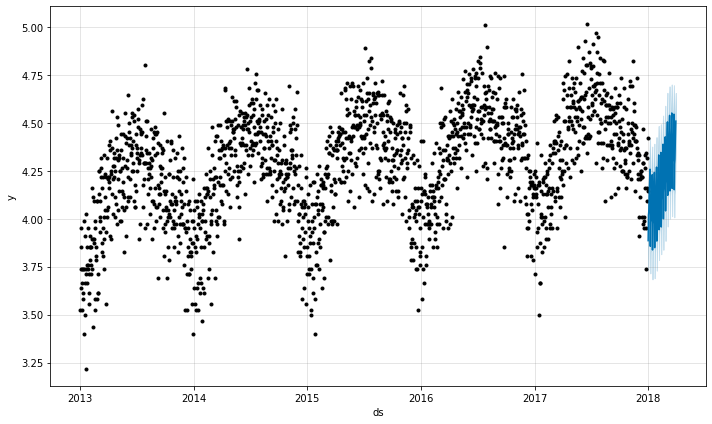

In [ ]:
forecastplot = model.plot(forecast)

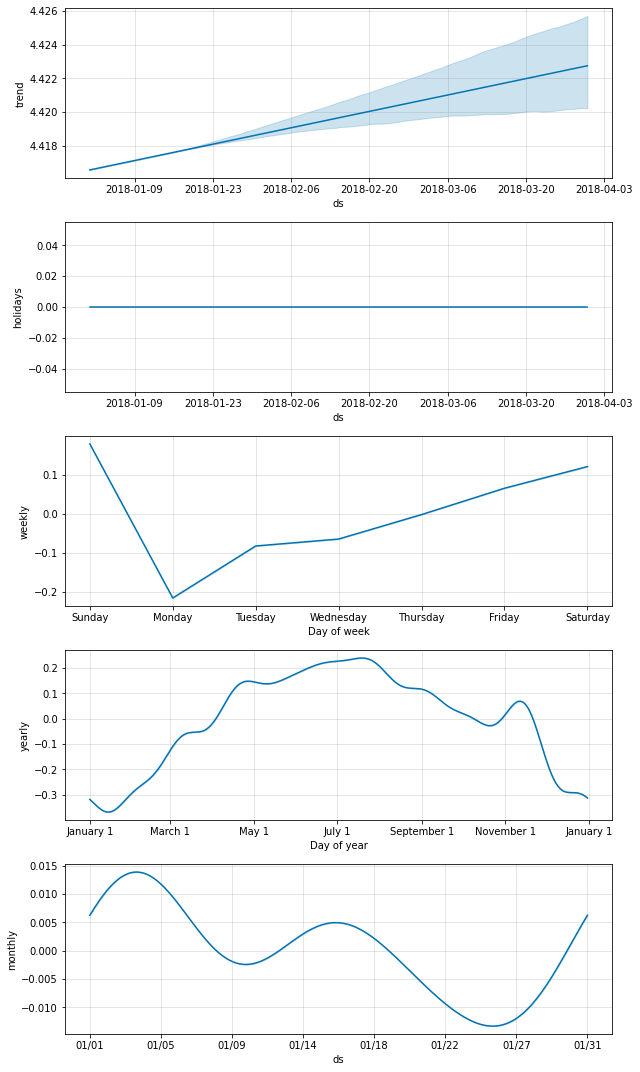

In [ ]:
fig = model.plot_components(forecast)

## Ensembling Experiments (After Tuning)


> The improved catboost and Prophet models showed improvement to forecasting accuracy (observed in Experiment 6) - especially with a custom ratio of weighted average (60% catboost 40% prophet instead of 50-50 in Experiment 9). From ensembled learning before tuning, rounded sales figures showed better SMAPE scores, which is also applied for all experiments below. Experiment 10 showed that the ensembling of all 5 models did not produce the best result, possibly due to higher inaccuracies in forecasting for the pre-tuned models.



In [ ]:
import pandas as pd
df1_1 = pd.read_csv("/content/submission_catboost.csv")
df1_2 = pd.read_csv("/content/submission_catboost_2.csv")
df1_3 = pd.read_csv("/content/submission_catboost_3.csv")
df2_1 = pd.read_csv("/content/submission_prophet_1.csv")
df2_2 = pd.read_csv("/content/submission_prophet_2.csv")

exp_df = df1_1 # make a duplicate for experiments

Experiment 5

In [ ]:
exp_df['sales'] = (0.6*df1_1['sales']) + (0.4*df2_1['sales'])
exp_df.to_csv('/content/submission_ens5.csv', index=False)
exp_df

,id,sales
0,0,12.082122
1,1,14.268432
2,2,14.571210
3,3,15.012999
4,4,16.650520
...,...,...
44995,44995,69.836554
44996,44996,71.387914
44997,44997,76.723819
44998,44998,81.459730


In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens5_rounded.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,14
2,2,15
3,3,15
4,4,17
...,...,...
44995,44995,70
44996,44996,71
44997,44997,77
44998,44998,81


Experiment 6 - BEST

In [ ]:
exp_df['sales'] = (0.6*df1_2['sales']) + (0.4*df2_2['sales'])
exp_df

,id,sales
0,0,12.136106
1,1,14.095992
2,2,14.373723
3,3,14.830201
4,4,16.564332
...,...,...
44995,44995,69.745146
44996,44996,71.116502
44997,44997,76.547201
44998,44998,81.337132


In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int)
exp_df.to_csv('/content/submission_ens6_rounded-2.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,14
2,2,14
3,3,15
4,4,17
...,...,...
44995,44995,70
44996,44996,71
44997,44997,77
44998,44998,81


Experiment 7 - SECOND BEST

In [ ]:
exp_df['sales'] = (0.6*df1_2['sales']) + (0.4*df2_1['sales'])
exp_df

,id,sales
0,0,12.076168
1,1,14.137997
2,2,14.487517
3,3,14.936580
4,4,16.727825
...,...,...
44995,44995,69.763699
44996,44996,71.541559
44997,44997,76.943175
44998,44998,81.410528


In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df.to_csv('/content/submission_ens7_rounded_v2.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,14
2,2,14
3,3,15
4,4,17
...,...,...
44995,44995,70
44996,44996,72
44997,44997,77
44998,44998,81


Experiment 8

In [ ]:
exp_df['sales'] = (0.6*df1_3['sales']) + (0.4*df2_1['sales'])
exp_df

,id,sales
0,0,12.385574
1,1,14.716202
2,2,15.084407
3,3,15.487217
4,4,16.361156
...,...,...
44995,44995,69.519644
44996,44996,71.472747
44997,44997,77.066711
44998,44998,81.254488


In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens8_rounded.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,15
2,2,15
3,3,15
4,4,16
...,...,...
44995,44995,70
44996,44996,71
44997,44997,77
44998,44998,81


Experiment 9

In [ ]:
exp_df['sales'] = (0.5*df1_2['sales']) + (0.5*df2_2['sales'])
exp_df

,id,sales
0,0,12.172954
1,1,14.133684
2,2,14.449109
3,3,14.925941
4,4,16.585287
...,...,...
44995,44995,70.057889
44996,44996,71.447107
44997,44997,76.824694
44998,44998,81.822079


In [ ]:
import numpy as np
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens9_rounded.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,14
2,2,14
3,3,15
4,4,17
...,...,...
44995,44995,70
44996,44996,71
44997,44997,77
44998,44998,82


Experiment 10

In [ ]:
exp_df['sales'] = (0.45*((df1_1['sales']+df1_2['sales']+df1_3['sales'])/3)) + (0.55*(((0.5*df2_1['sales'])+(0.5*df2_2['sales']))))
exp_df

,id,sales
0,0,12.230499
1,1,14.391178
2,2,14.756104
3,3,15.222814
4,4,16.577846
...,...,...
44995,44995,70.202429
44996,44996,71.810611
44997,44997,77.156878
44998,44998,82.100603


In [ ]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('/content/submission_ens10_rounded.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,14
2,2,15
3,3,15
4,4,17
...,...,...
44995,44995,70
44996,44996,72
44997,44997,77
44998,44998,82
